## Import modules

In [9]:
import collections
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from dataset_exploration.utils import create_histogram, read_annotation
from configs.utils import get_dataset_dir
import sys
from analyze_stuff import get_config, get_dataloader

## Load data

In [10]:
config_path = "../configs/tdt4265.py"
cfg = get_config(config_path)
dataset_to_analyze = "train"  # or "val"
dataloader = get_dataloader(cfg, dataset_to_analyze)

# Aspect ratio distribution

In [11]:
def create_object_aspect_ratio_histogram(annotations, object):
    aspect_ratios = {}
    print(f"Object is: {object}")
    category = next(
        item for item in annotations["categories"] if item["name"] == object
    )
    category_id = category["id"]
    filtered_annotations = list(
        filter(lambda x: x["category_id"] == category_id, annotations["annotations"])
    )

    for annotation in filtered_annotations:
        height = annotation["bbox"][3]
        width = annotation["bbox"][2]
        aspect_ratio = round(height / width, 1)
        try:
            aspect_ratios[aspect_ratio] += 1
        except KeyError:
            aspect_ratios[aspect_ratio] = 1
    max_value = None
    if bool(aspect_ratios):
        max_value = max(aspect_ratios.values())

    if bool(max_value):
        aspect_ratios = {
            k: v for (k, v) in aspect_ratios.items() if v > max_value * 0.1
        }
    create_histogram(
        collections.OrderedDict(sorted(aspect_ratios.items())),
        x_label="Aspect ratios",
        y_label="Objects",
        title=f"Aspect ratios histogram for {object}",
        show=True,
        figsize=(15, 6),
        xtick_fontsize=10,
        xtick_rotation=0
    )

Object is: car


<Figure size 432x288 with 0 Axes>

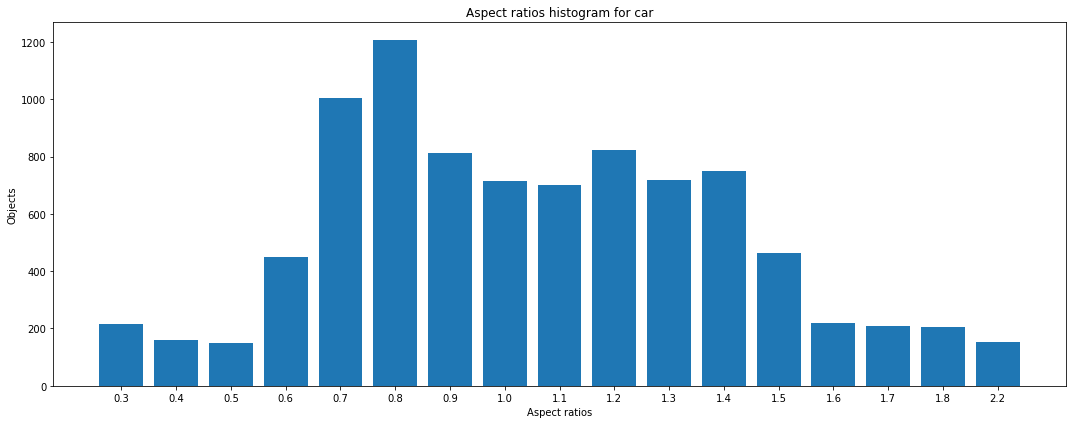

Object is: truck


<Figure size 432x288 with 0 Axes>

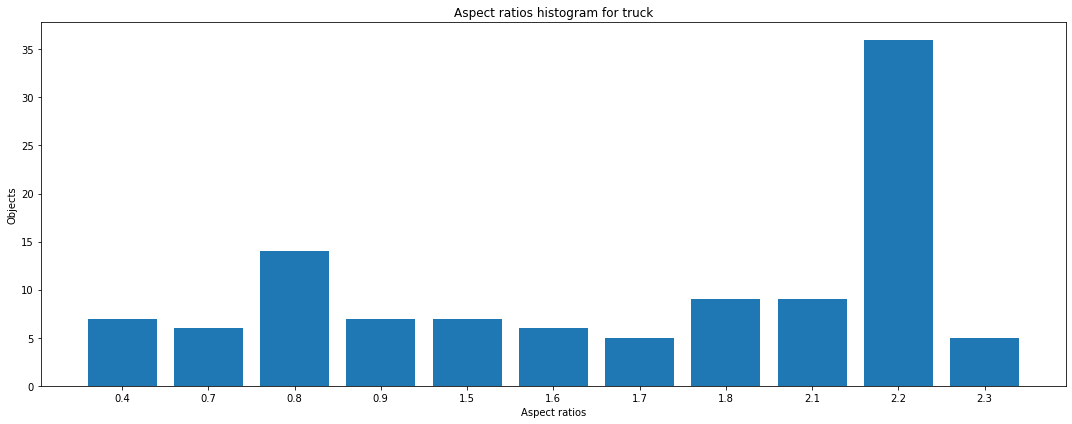

Object is: bus


<Figure size 432x288 with 0 Axes>

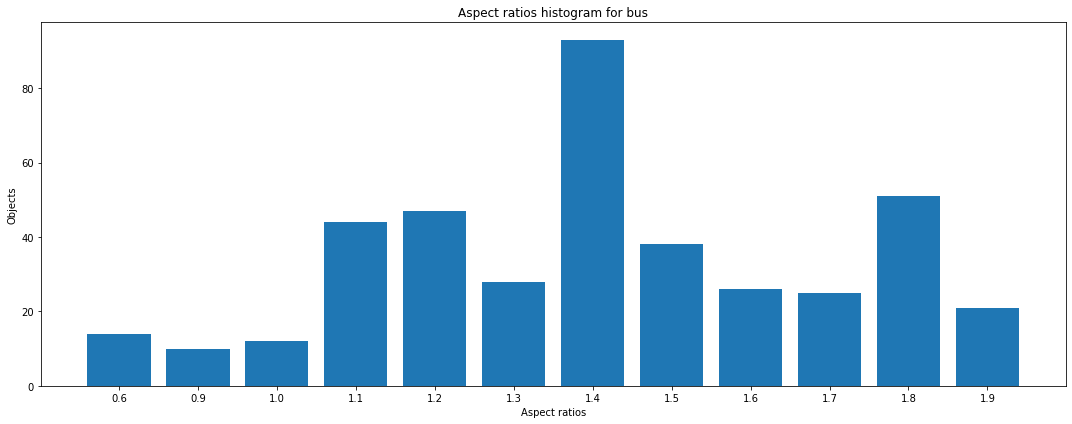

Object is: motorcycle


<Figure size 432x288 with 0 Axes>

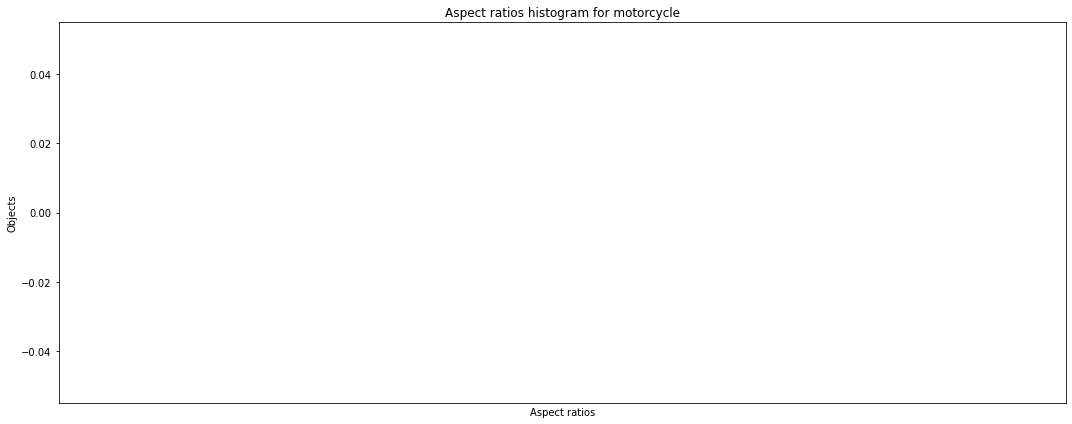

Object is: bicycle


<Figure size 432x288 with 0 Axes>

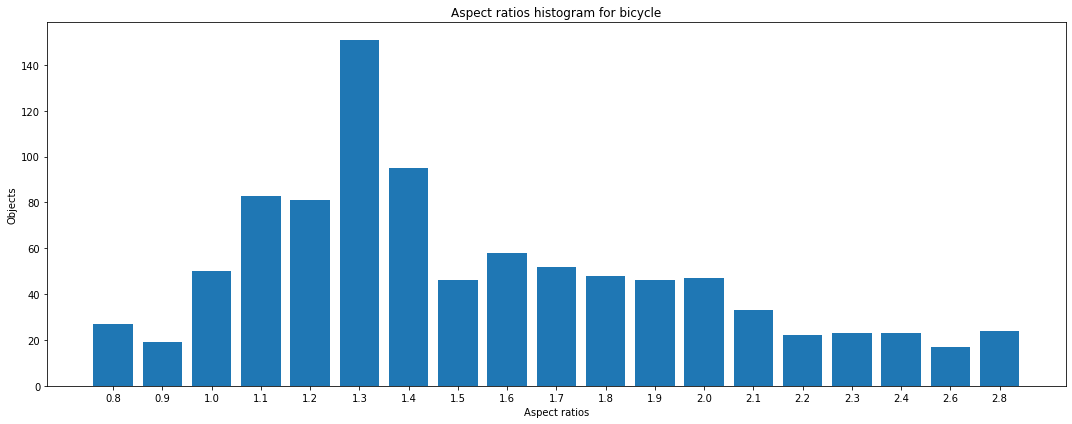

Object is: scooter


<Figure size 432x288 with 0 Axes>

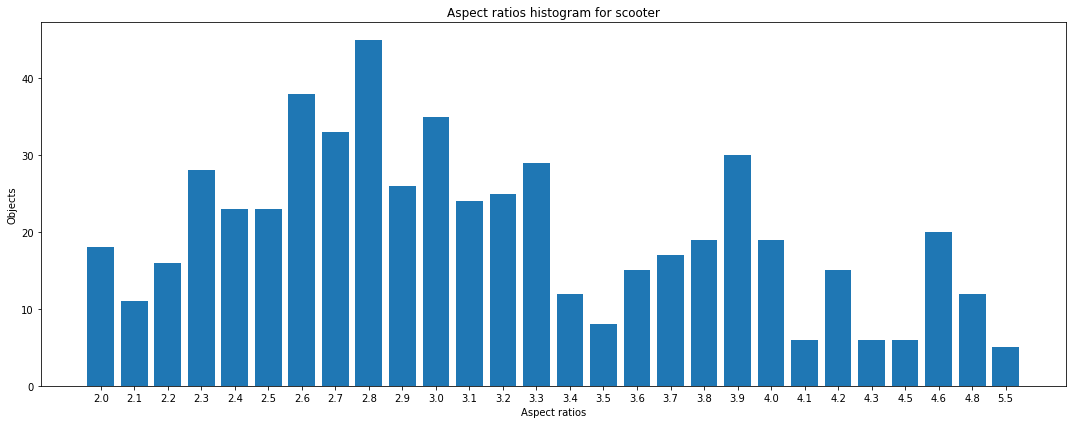

Object is: person


<Figure size 432x288 with 0 Axes>

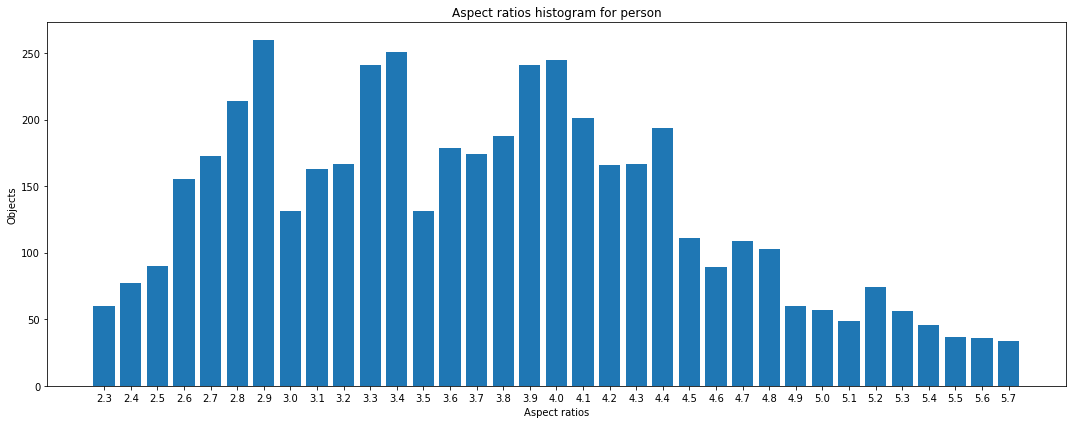

Object is: rider


<Figure size 432x288 with 0 Axes>

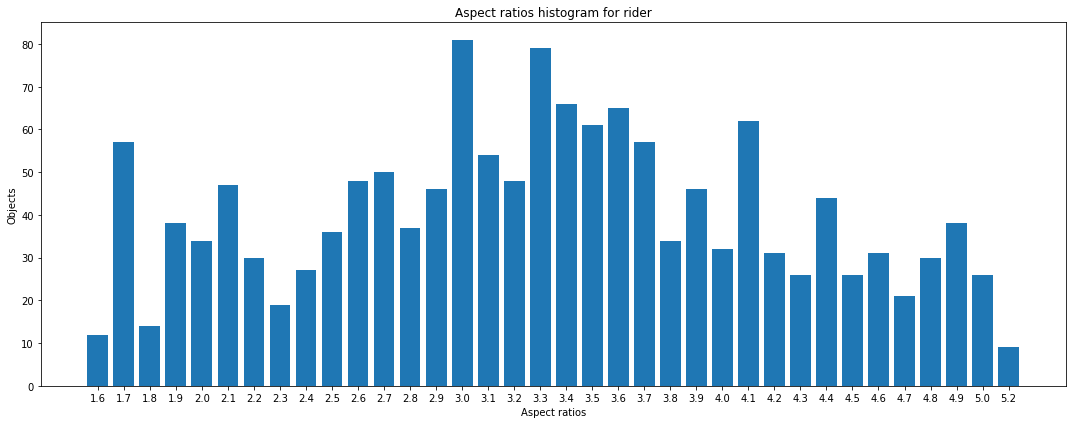

In [12]:
annotations_train = read_annotation(get_dataset_dir("tdt4265_2022/train_annotations.json"))
for category in annotations_train["categories"]:
    create_object_aspect_ratio_histogram(annotations_train, object=category["name"])